Выполнил Смердов Антон, 474 группа

In [87]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import xarray as xr
import itertools

Заранее определяем параметры графиков.

In [88]:
mpl.rcParams['figure.figsize'] = (20,16)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['lines.linewidth'] = 3

# Первый случай.

Мы решаем систему

\begin{gather}
\dot{x} = x\big(1 - 0.5x - \frac2{7\alpha^2}y\big)\\
\dot{y} = y\big(2\alpha - 3.5\alpha^2x - 0.5y\big)\\
\dot{\alpha} = \varepsilon\big(2 - 7\alpha x\big)
\end{gather}




Для общности введём списки различных значений параметров и будем решать задачу для всех возможных комбинаций.

По условию начальное значения $\alpha$ равно 0, но т.к. делить на 0 нельзя, в качестве н.у. будем использовать 1.

In [104]:
T = 20 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.01,0.11,0.15], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a0_list = pd.Series([1], name = 'a0') # для alpha

## Метод РК 1-го порядка.

Разностные уравнения запишутся следующим образом:

\begin{gather}
\frac1\tau(x_{n+1} - x_n) = x_n\big(1 - 0.5x_n - \frac2{7\alpha_n^2}y_n\big)\\
\frac1\tau(y_{n+1} - y_n) = y\big(2\alpha_n - 3.5\alpha_n^2x_n - 0.5y_n\big)\\
\frac1\tau(\alpha_{n+1} - \alpha_n) = \varepsilon\big(2 - 7\alpha_n x_n\big)
\end{gather}

Создадим функцию, вычисляющую эволюцию системы.

In [345]:
def calc_evolution_rk_1_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list, eps_list = eps_list, T = T,\
                   tau_list = tau_list):
    '''
    Input:
    tau_list, x0_list, y0_list, a0_list, eps_list : списки значений шага tau, начальных условий x0, y0,
        a0 и параметра epsilon
    T : конечный момент времени

    Output:
    evolution_table : pd.DataFrame - таблица с историей эволюции для каждой комбинации параметров
    '''
    features_list = ['tau','x0','y0','a0','eps','t','x','y','a'] # названия столбцов в итоговой таблице
    evolution_table = pd.DataFrame(columns=features_list) # таблица, в которую будем записывать данные
    
    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        t = 0
        x = x0; y = y0; a = a0
        row_to_append = pd.Series([tau, x0, y0, a0, eps, t, x, y, a],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            # Здесь начинается метод РК 1-го порядка. Так как альфа может быть 0, то перед его возведением в -1
            # степень ограничим альфу снизу до 0.1 по модулю.
            t+=tau
            x_new = x + tau*x*(1-0.5*x-2*y/(7*(max(abs(a),1e-1)**2)))
            y_new = y + tau*y*(2*a-3.5*x*a**2-0.5*y)
            a_new = a + tau*eps*(2-7*a*x)
            x = x_new; y = y_new; a = a_new
            row_to_append[:] = tau, x0, y0, a0, eps, t, x, y, a
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a)) > 1e5: # если переполнение - то останавливаемся
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a0','eps'])
    return evolution_table

Для построения графиков создадим отдельную функцию.

In [106]:
def plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16)):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax0, ax1, ax2, ax3 = axes.flatten()

    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        label = ''
        title = ''
        for param, param_list in zip([tau, x0, y0, a0, eps],[tau_list,x0_list,y0_list,a0_list,eps_list]):
            if len(param_list) > 1: label = label + param_list.name + ' =' + str(param) + ', '
            else: title = title + param_list.name + ' =' + str(param) + ', '
        ax0.plot(evolution_table.loc[tau, x0, y0, a0, eps]['t'],evolution_table.loc[tau, x0, y0, a0, eps]['x'],label=label)
        ax0.set_xlabel('t')
        ax0.set_ylabel('x')
        ax1.plot(evolution_table.loc[tau, x0, y0, a0, eps]['t'],evolution_table.loc[tau, x0, y0, a0, eps]['y'],label=label)
        ax1.set_xlabel('t')
        ax1.set_ylabel('y')
        ax2.plot(evolution_table.loc[tau, x0, y0, a0, eps]['t'],evolution_table.loc[tau, x0, y0, a0, eps]['a'],label=label)
        ax2.set_xlabel('t')
        ax2.set_ylabel('a')
        ax3.plot(evolution_table.loc[tau, x0, y0, a0, eps]['x'],evolution_table.loc[tau, x0, y0, a0, eps]['y'],label=label)
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')

    fig.suptitle(title)
        
    for ax in axes.flatten():
        ax.legend()

Вычисляем эволюцию системы.

In [107]:
evolution_table = calc_evolution_rk_1_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

Видно, что при $\tau = 0.10$ схема начинает расходиться.

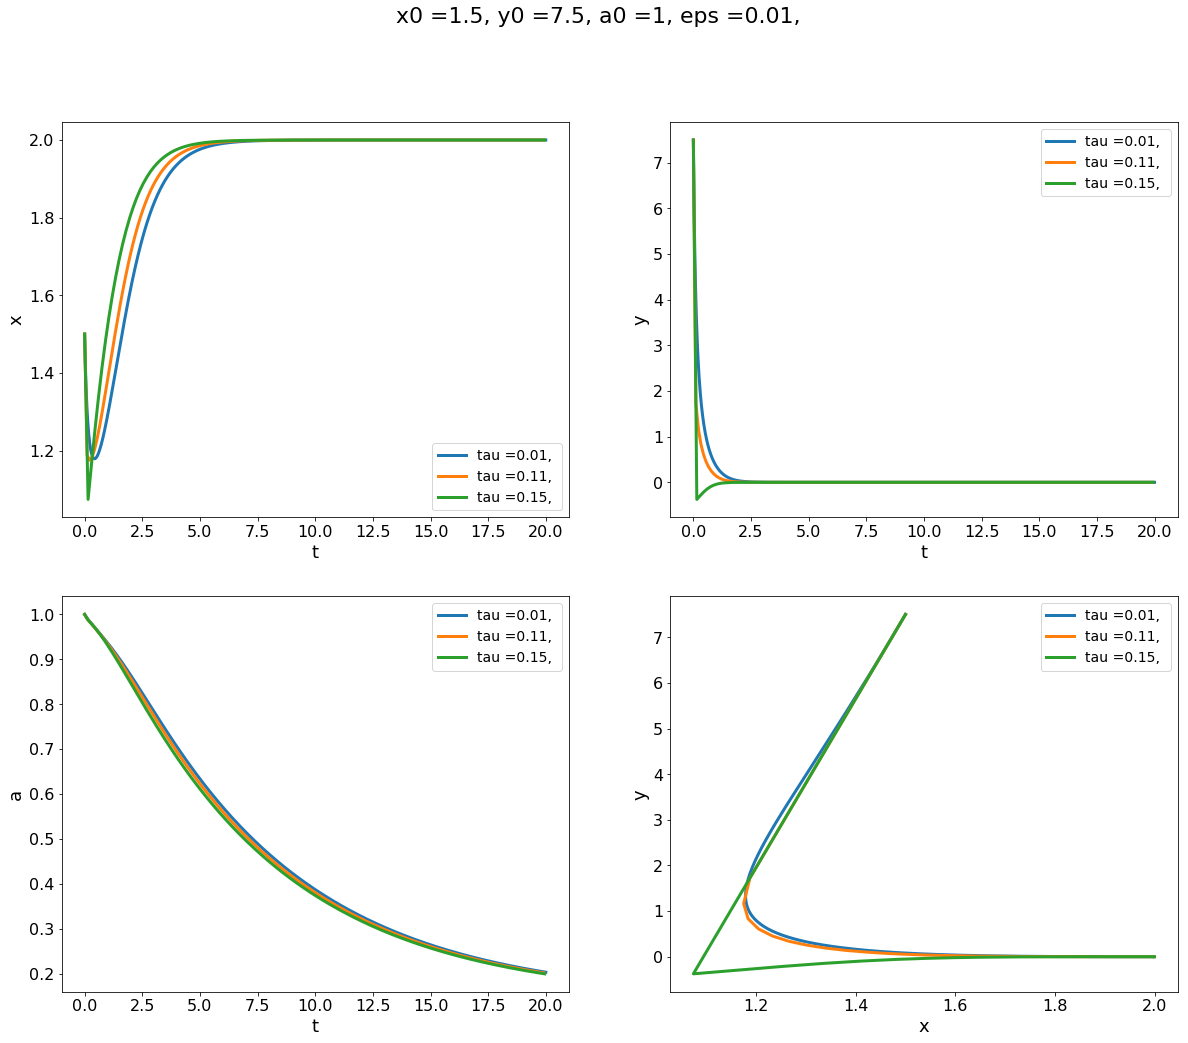

In [108]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

Если взять начальное значение $\alpha$ равным 0, как предлагается в условии, то 

In [200]:
T = 50 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.001], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([0.1,2], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([1,10], name = 'y0') # для y
a0_list = pd.Series([0], name = 'a0') # для alpha

In [194]:
evolution_table = calc_evolution_rk_1_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

In [198]:
evolution_table

t              x         y        a
tau   x0  y0   a0  eps                                           
0.001 0.1 1.0  0.0 0.01   0.000   1.000000e-01  1.000000  0.00000
                   0.01   0.001   9.723786e-02  0.999500  0.00002
                   0.01   0.002   9.455353e-02  0.999001  0.00004
                   0.01   0.003   9.194479e-02  0.998502  0.00006
                   0.01   0.004   8.940945e-02  0.998003  0.00008
                   0.01   0.005   8.694540e-02  0.997505  0.00010
                   0.01   0.006   8.455061e-02  0.997008  0.00012
                   0.01   0.007   8.222308e-02  0.996511  0.00014
                   0.01   0.008   7.996089e-02  0.996015  0.00016
                   0.01   0.009   7.776216e-02  0.995519  0.00018
                   0.01   0.010   7.562508e-02  0.995024  0.00020
                   0.01   0.011   7.354788e-02  0.994530  0.00022
                   0.01   0.012   7.152885e-02  0.994035  0.00024
                   0.01   0.013   6.956633e-02  0.993542  0.00026
                   0.01   0.014   6.765870e-02  0.993049  0.00028
                   0.01   0.015   6.580440e-02  0.992556  0.00030
                   0.01   0.016   6.400191e-02  0.992064  0.00032
                   0.01   0.017   6.224975e-02  0.991573  0.00034
                   0.01   0.018   6.054649e-02  0.991082  0.00036
                   0.01   0.019   5.889073e-02  0.990592  0.00038
                   0.01   0.020   5.728112e-02  0.990102  0.00040
                   0.01   0.021   5.571636e-02  0.989612  0.00042
                   0.01   0.022   5.419517e-02  0.989123  0.00044
                   0.01   0.023   5.271630e-02  0.988635  0.00046
                   0.01   0.024   5.127857e-02  0.988147  0.00048
                   0.01   0.025   4.988079e-02  0.987660  0.00050
                   0.01   0.026   4.852185e-02  0.987173  0.00052
                   0.01   0.027   4.720064e-02  0.986687  0.00054
                   0.01   0.028   4.591609e-02  0.986201  0.00056
                   0.01   0.029   4.466716e-02  0.985716  0.00058
...                         ...            ...       ...      ...
      2.0 10.0 0.0 0.01  49.971  1.547451e-120  3.956812  0.99942
                   0.01  49.972  1.547247e-120  3.956893  0.99944
                   0.01  49.973  1.547043e-120  3.956974  0.99946
                   0.01  49.974  1.546839e-120  3.957054  0.99948
                   0.01  49.975  1.546635e-120  3.957135  0.99950
                   0.01  49.976  1.546431e-120  3.957216  0.99952
                   0.01  49.977  1.546228e-120  3.957297  0.99954
                   0.01  49.978  1.546024e-120  3.957378  0.99956
                   0.01  49.979  1.545820e-120  3.957459  0.99958
                   0.01  49.980  1.545617e-120  3.957540  0.99960
                   0.01  49.981  1.545413e-120  3.957620  0.99962
                   0.01  49.982  1.545210e-120  3.957701  0.99964
                   0.01  49.983  1.545007e-120  3.957782  0.99966
                   0.01  49.984  1.544804e-120  3.957863  0.99968
                   0.01  49.985  1.544600e-120  3.957944  0.99970
                   0.01  49.986  1.544397e-120  3.958025  0.99972
                   0.01  49.987  1.544194e-120  3.958106  0.99974
                   0.01  49.988  1.543991e-120  3.958186  0.99976
                   0.01  49.989  1.543788e-120  3.958267  0.99978
                   0.01  49.990  1.543585e-120  3.958348  0.99980
                   0.01  49.991  1.543382e-120  3.958429  0.99982
                   0.01  49.992  1.543180e-120  3.958510  0.99984
                   0.01  49.993  1.542977e-120  3.958591  0.99986
                   0.01  49.994  1.542774e-120  3.958672  0.99988
                   0.01  49.995  1.542572e-120  3.958752  0.99990
                   0.01  49.996  1.542369e-120  3.958833  0.99992
                   0.01  49.997  1.542167e-120  3.958914  0.99994
                   0.01  49.998  1.541964e-120  3.958995  0.99996
    

Как легко видеть, популяция $x$ просто исчезла.

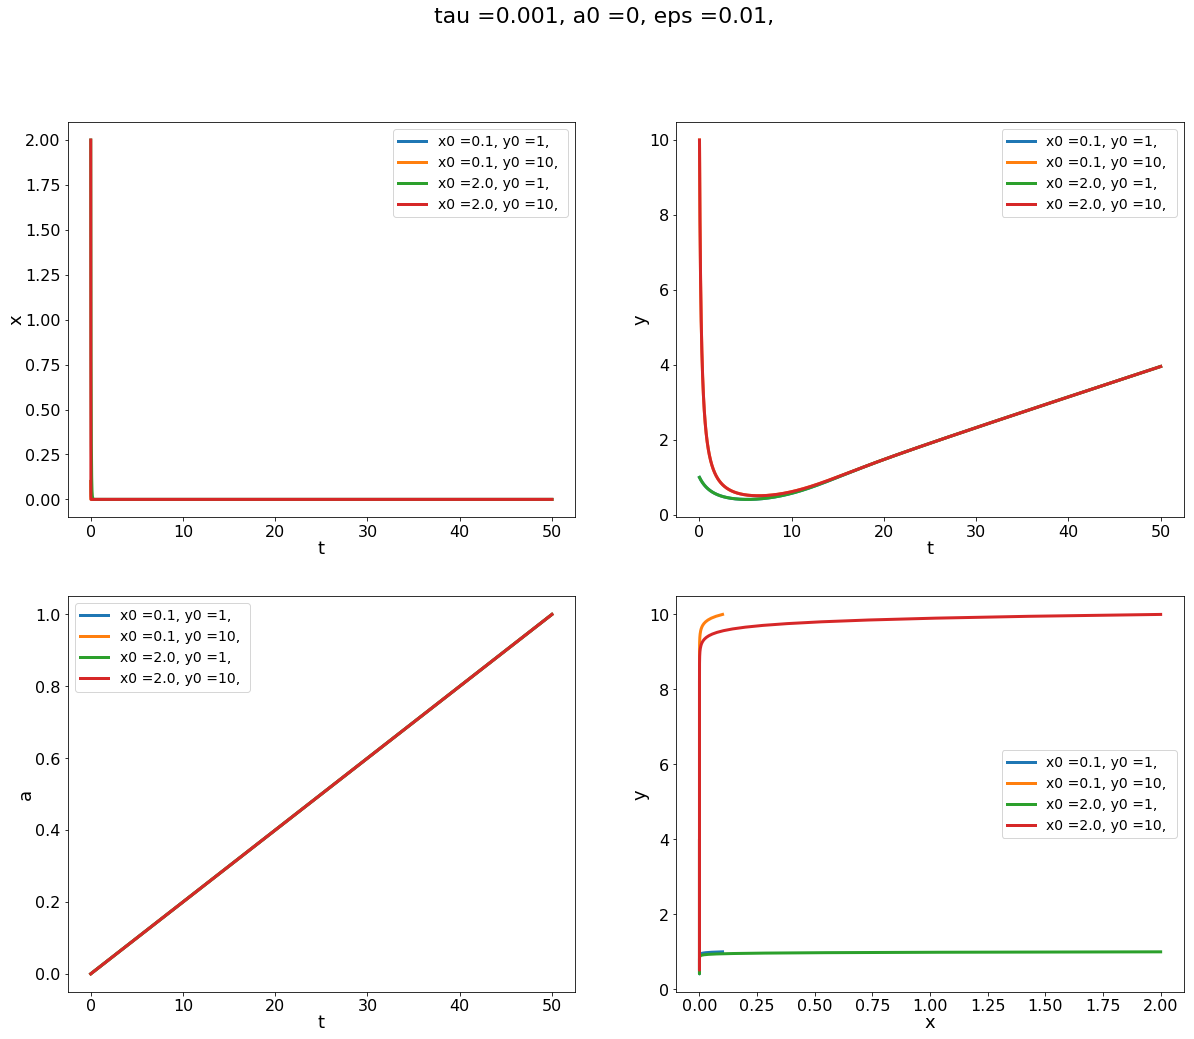

In [201]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

Смотрим на систему, когда время увеличено до 2000.

In [174]:
T = 2000 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.05], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([0.1,2], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([1,10], name = 'y0') # для y
a0_list = pd.Series([0.8,1.25], name = 'a0') # для alpha

In [175]:
evolution_table = calc_evolution_rk_1_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

На этих графиках видно, что при положительных $\alpha$ популяция $x$ всегда "съедает" $y$.

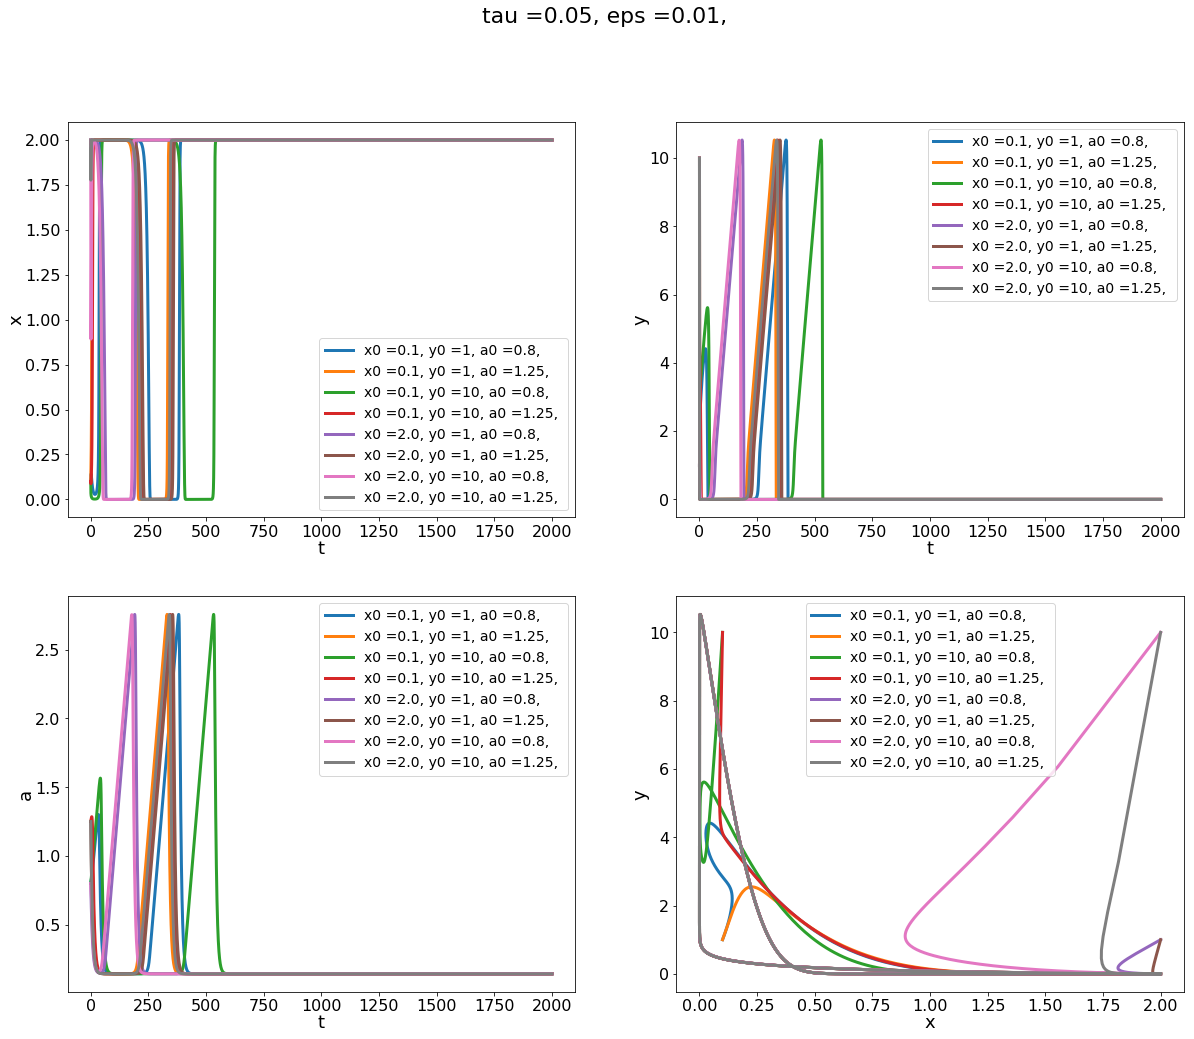

In [176]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

Зададим отрицательные $a$.

In [228]:
T = 1000 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.05], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([0.1,2], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([1,10], name = 'y0') # для y
a0_list = pd.Series([-0.8,-1.25], name = 'a0') # для alpha

In [229]:
evolution_table = calc_evolution_rk_1_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

Как видно, знак $\alpha$ меняется, и $x$ "съедает" $y$.

/home/asm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/asm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/asm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/asm/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.


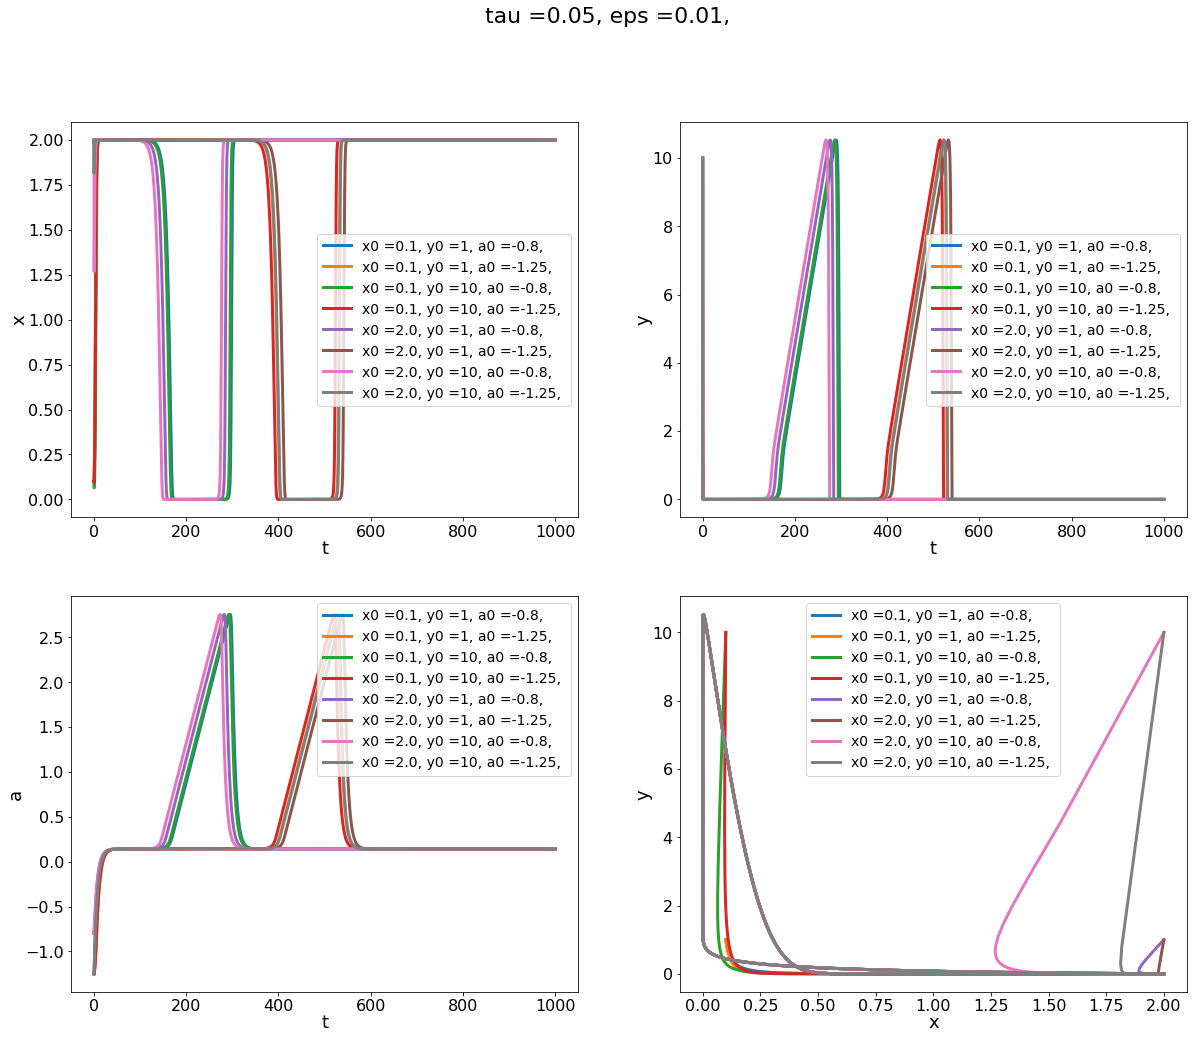

In [230]:
plot_it(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

## Метод РК 4-го порядка.

\begin{gather}
\dot{x} = x\big(1 - 0.5x - \frac2{7\alpha^2}y\big)\\
\dot{y} = y\big(2\alpha - 3.5\alpha^2x - 0.5y\big)\\
\dot{\alpha} = \varepsilon\big(2 - 7\alpha x\big)
\end{gather}

Вычисление нового значения проходит в четыре стадии:

\begin{gather*}
k_1 = f(x_n, y_n)\\
k_2 = f(x_n+\frac{h}2, y_n + \frac{h}2k_1)\\
k_3 = f(x_n+\frac{h}2, y_n + \frac{h}2k_2)\\
k_4 = f(x_n+h, y_n + hk_3)
\end{gather*}

\begin{gather*}
y_{n+1} = y_n + \frac{h}6(k_1+2k_2+2k_3+k_4)
\end{gather*}


Вспомогательные функции:

In [28]:
def f_1(x,y,a):
    # Так как альфа может быть 0, то перед его возведением в -1
    # степень ограничим альфу снизу до 0.1 по модулю.
    return x*(1-0.5*x-2*y/(7*(max(abs(a),1e-1)**2)))
    
def f_2(x,y,a):
    return y*(2*a-3.5*x*a**2-0.5*y)

def f_3(x,y,a,eps):
    return eps*(2-7*a*x)

def f(val_list,eps):
    k_list = []
    k_list.append(f_1(val_list[0],val_list[1],val_list[2]))
    k_list.append(f_2(val_list[0],val_list[1],val_list[2]))
    k_list.append(f_3(val_list[0],val_list[1],val_list[2],eps))
    return np.array(k_list)

In [42]:
def calc_evolution_rk_4_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list, eps_list = eps_list, T = T,\
                   tau_list = tau_list):
    '''
    Input:
    tau_list, x0_list, y0_list, a0_list, eps_list : списки значений шага tau, начальных условий x0, y0,
        a0 и параметра epsilon
    T : конечный момент времени

    Output:
    evolution_table : pd.DataFrame - таблица с историей эволюции для каждой комбинации параметров
    '''
    features_list = ['tau','x0','y0','a0','eps','t','x','y','a'] # названия столбцов в итоговой таблице
    evolution_table = pd.DataFrame(columns=features_list) # таблица, в которую будем записывать данные
    
    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        t = 0
        x = x0; y = y0; a = a0
        row_to_append = pd.Series([tau, x0, y0, a0, eps, t, x, y, a],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            # Здесь начинается метод РК 4-го порядка. 
            vals = np.array([x,y,a])
            k1 = f(vals,eps)
            k2 = f(vals+tau*k1/2,eps)
            k3 = f(vals+tau*k2/2,eps)
            k4 = f(vals+tau*k3,eps)
            vals_new = vals + tau/6*(k1+2*k2+2*k3+k4)
            t+=tau
            x, y, a = vals_new[0], vals_new[1], vals_new[2]
            row_to_append[:] = tau, x0, y0, a0, eps, t, x, y, a
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a)) > 1e5: # если переполнение - то останавливаемся
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a0','eps'])
    return evolution_table


In [84]:
T = 20 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.03,0.15,0.18,0.21], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a0_list = pd.Series([1], name = 'a0') # для alpha

In [85]:
evolution_table = calc_evolution_rk_4_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

Схема начинает расходится при $\tau \approx 0.15$.

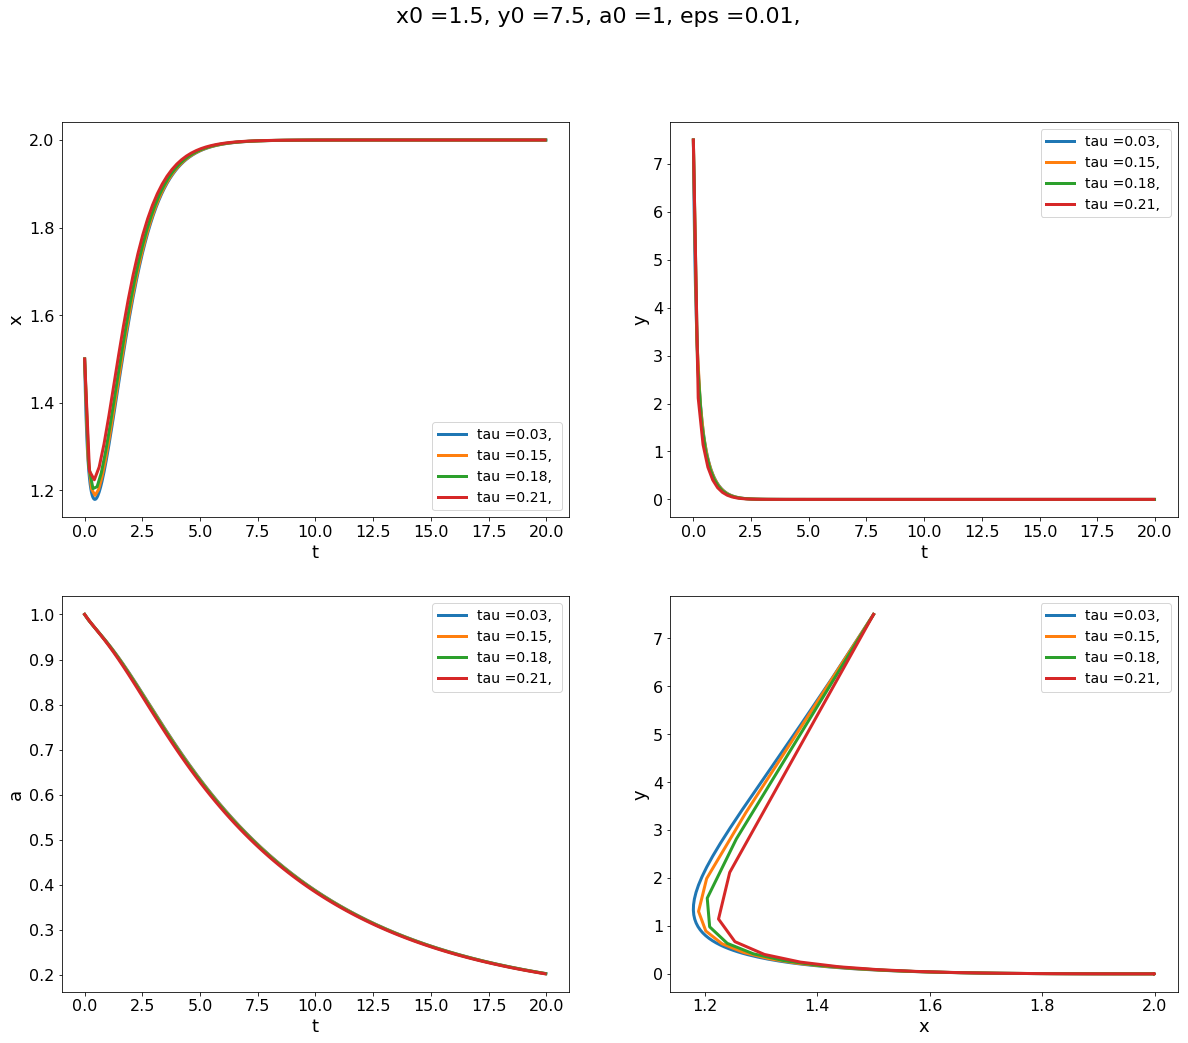

In [86]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

In [117]:
T = 1000 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.02], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a0_list = pd.Series([1], name = 'a0') # для alpha

In [118]:
evolution_table = calc_evolution_rk_4_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

In [ ]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

## Неявный метод РК (метод Хаммера-Холлинсворта)

\begin{gather}
\dot{x} = x\big(1 - 0.5x - \frac2{7\alpha^2}y\big)\\
\dot{y} = y\big(2\alpha - 3.5\alpha^2x - 0.5y\big)\\
\dot{\alpha} = \varepsilon\big(2 - 7\alpha x\big)
\end{gather}

Это двухэтапный неявный метод четвёртого порядка:

\begin{gather}
y_{n+1} = y_n + \frac{(k_1+k_2)}2,
\end{gather}
где
\begin{gather}
&k_1 = hf(x_n+(\frac12-\frac{\sqrt{3}}6)h, \ y_n+ \frac{k_1}4 + (\frac14 - \frac{\sqrt{3}}6)k_2)\\
&k_2 = hf(x_n+(\frac12+\frac{\sqrt{3}}6)h, \ y_n+ (\frac14 + \frac{\sqrt{3}}6)k_1 + \frac{k_2}4)
\end{gather}

In [182]:
def k_1(var_list,eps,k1,k2,tau):
    return tau*f(var_list+k1/4+(1/4-np.sqrt(3)/6)*k2,eps)

In [183]:
def k_2(var_list,eps,k1,k2,tau):
    return tau*f(var_list+(1/4+np.sqrt(3)/6)*k1+k2/4,eps)

In [385]:
k1 = 0; k2 = 0; var_list = np.array([1,1,1]); eps = 1e-2; tau = 0.05

In [386]:
k1 = k_1(var_list,eps,k1,k2,tau)
k2 = k_2(var_list,eps,k1,k2,tau)
print(k1)
print(k2)

ValueError: not enough values to unpack (expected 4, got 3)

In [197]:
def calc_evolution_hh_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list, eps_list = eps_list, T = T,\
                   tau_list = tau_list):
    '''
    Input:
    tau_list, x0_list, y0_list, a0_list, eps_list : списки значений шага tau, начальных условий x0, y0,
        a0 и параметра epsilon
    T : конечный момент времени

    Output:
    evolution_table : pd.DataFrame - таблица с историей эволюции для каждой комбинации параметров
    '''
    features_list = ['tau','x0','y0','a0','eps','t','x','y','a'] # названия столбцов в итоговой таблице
    evolution_table = pd.DataFrame(columns=features_list) # таблица, в которую будем записывать данные
    
    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        t = 0
        x = x0; y = y0; a = a0
        row_to_append = pd.Series([tau, x0, y0, a0, eps, t, x, y, a],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            vals = np.array([x,y,a])
            k1 = 0; k2 = 0
            for j in range(2):
                k1 = k_1(vals,eps,k1,k2,tau)
                k2 = k_2(vals,eps,k1,k2,tau)
            vals_new = vals + (k1+k2)/2
            t+=tau
            x, y, a = vals_new[0], vals_new[1], vals_new[2]
            row_to_append[:] = tau, x0, y0, a0, eps, t, x, y, a
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a)) > 1e5: # если переполнение - то останавливаемся
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a0','eps'])
    return evolution_table

In [222]:
T = 10 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.15,0.23,0.27,0.3], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a0_list = pd.Series([1], name = 'a0') # для alpha

In [223]:
evolution_table = calc_evolution_rk_4_problem_1(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

Схема начинает насходится при $\tau \approx 0.2$.

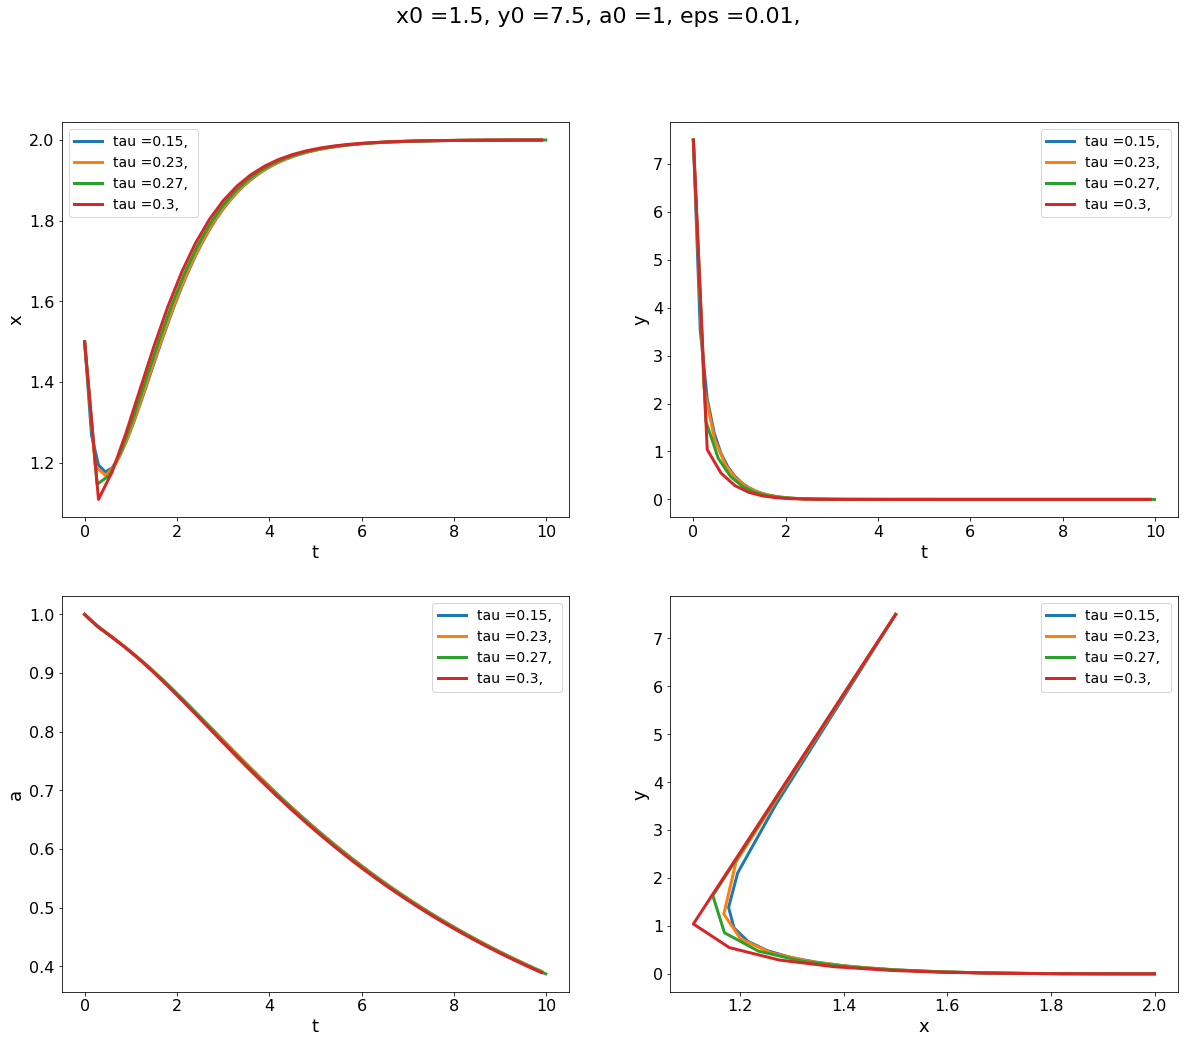

In [224]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

# Второй случай

Теперь генетических признака два.

\begin{gather}
\dot{x} = x\big(2\alpha_1 - 0.5x - \alpha_1^2\alpha_2^{-2}y\big)\\
\dot{y} = y\big(2\alpha_2 - \alpha_1^{-2}\alpha_2^2x - 0.5y\big)\\
\dot{\alpha_1} = \varepsilon\big(2 - 2\alpha_1\alpha_2^{-2}y\big)\\
\dot{\alpha_2} = \varepsilon\big(2 - 2\alpha_2\alpha_1^{-2}x\big)
\end{gather}

## Метод РК 1-го порядка.

Используем явный метод РК 1-го порядка.

\begin{gather}
\frac1\tau(x_{n+1} - x_n) = x_n\big(2\alpha_{1,n} - 0.5x_n - \alpha_{1,n}^2\alpha_{2,n}^{-2}y_n\big)\\
\frac1\tau(y_{n+1} - y_n) = y_n\big(2\alpha_{2,n} - \alpha_{1,n}^{-2}\alpha_{2,n}^2x_n - 0.5y_n\big)\\
\frac1\tau(\alpha_{1,n+1} - \alpha_{1,n}) = \varepsilon\big(2 - 2\alpha_{1,n}\alpha_{2,n}^{-2}y_n\big)\\
\frac1\tau(\alpha_{2,n+1} - \alpha_{2,n}) = \varepsilon\big(2 - 2\alpha_{2,n}\alpha_{1,n}^{-2}x_n\big)
\end{gather}

In [293]:
def calc_evolution_rk_1_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list):
    features_list = ['tau','x0','y0','a10','a20','eps','t','x','y','a1','a2']
    evolution_table = pd.DataFrame(columns=features_list)
    
    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list, a10_list, a20_list, eps_list):
        t = 0
        x = x0; y = y0; a1 = a10; a2 = a20
        row_to_append = pd.Series([tau, x0, y0, a10, a20, eps, t, x, y, a1, a2],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            t+=tau
            b1 = min(a1**(-2),100)
            b2 = min(a2**(-2),100)
            x_new = x + tau*x*(2*a1-0.5*x-a1**2*b2*y)
            y_new = y + tau*y*(2*a2-0.5*y-a2**2*b1*x)
            a1_new = a1 + tau*eps*(2-2*a1*b2*y)
            a2_new = a2 + tau*eps*(2-2*a2*b1*x)
            x = x_new; y = y_new; a1 = a1_new; a2 = a2_new
            row_to_append[:] = tau, x0, y0, a10, a20, eps, t, x, y, a1, a2
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a1),abs(a2)) > 1e5:
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a10','a20','eps'])
    return evolution_table

Настроим начальные параметры.

In [224]:
T = 100 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.001], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a10_list = pd.Series([1.], name = 'a10') # для alpha
a20_list = pd.Series([10.], name = 'a20') # для alpha

Специальная функция для построения графиков.

In [246]:
def plot_it_problem_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16)):
    mpl.rcParams['figure.figsize'] = figsize
    fig, axes = plt.subplots(nrows=3, ncols=2)
    ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list,\
                                                    a10_list, a20_list, eps_list):
        label = ''
        title = ''
        for param, param_list in zip([tau, x0, y0, a10, a20, eps],[tau_list,x0_list,y0_list,a10_list,a20_list,eps_list]):
            if len(param_list) > 1: label = label + param_list.name + ' =' + str(param) + ', '
            else: title = title + param_list.name + ' =' + str(param) + ', '
        ax0.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['x'],label=label)
        ax0.set_xlabel('t')
        ax0.set_ylabel('x')
        ax1.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['y'],label=label)
        ax1.set_xlabel('t')
        ax1.set_ylabel('y')
        ax2.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['a1'],label=label)
        ax2.set_xlabel('t')
        ax2.set_ylabel('a1')
        ax3.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['a2'],label=label)
        ax3.set_xlabel('t')
        ax3.set_ylabel('a2')
        ax4.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['x'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['y'],label=label)
        ax4.set_xlabel('x')
        ax4.set_ylabel('y')

    fig.suptitle(title)
        
    for ax in axes.flatten():
        ax.legend()

In [225]:
evolution_table = calc_evolution_rk_1_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list)

Победила популяция $x$, и от $y$ практически ничего не осталось.

/home/asm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


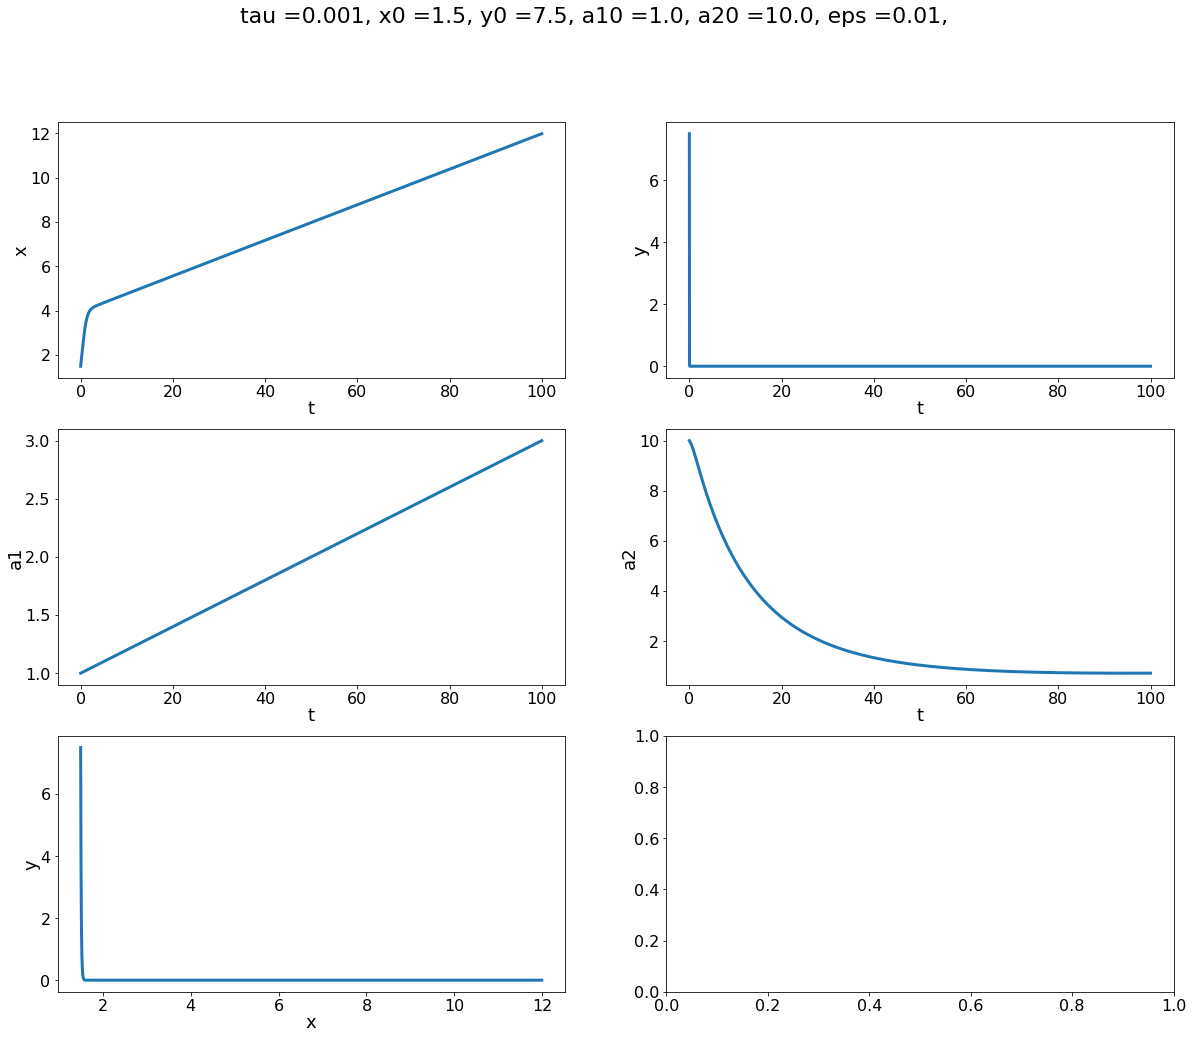

In [226]:
plot_it_problem_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16))

In [315]:
T = 0.5 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.005,0.0075], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a10_list = pd.Series([1.], name = 'a10') # для alpha
a20_list = pd.Series([10.], name = 'a20') # для alpha

In [316]:
evolution_table = calc_evolution_rk_1_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list)

Расхождение при $\tau \approx 0.005 $.

/home/asm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


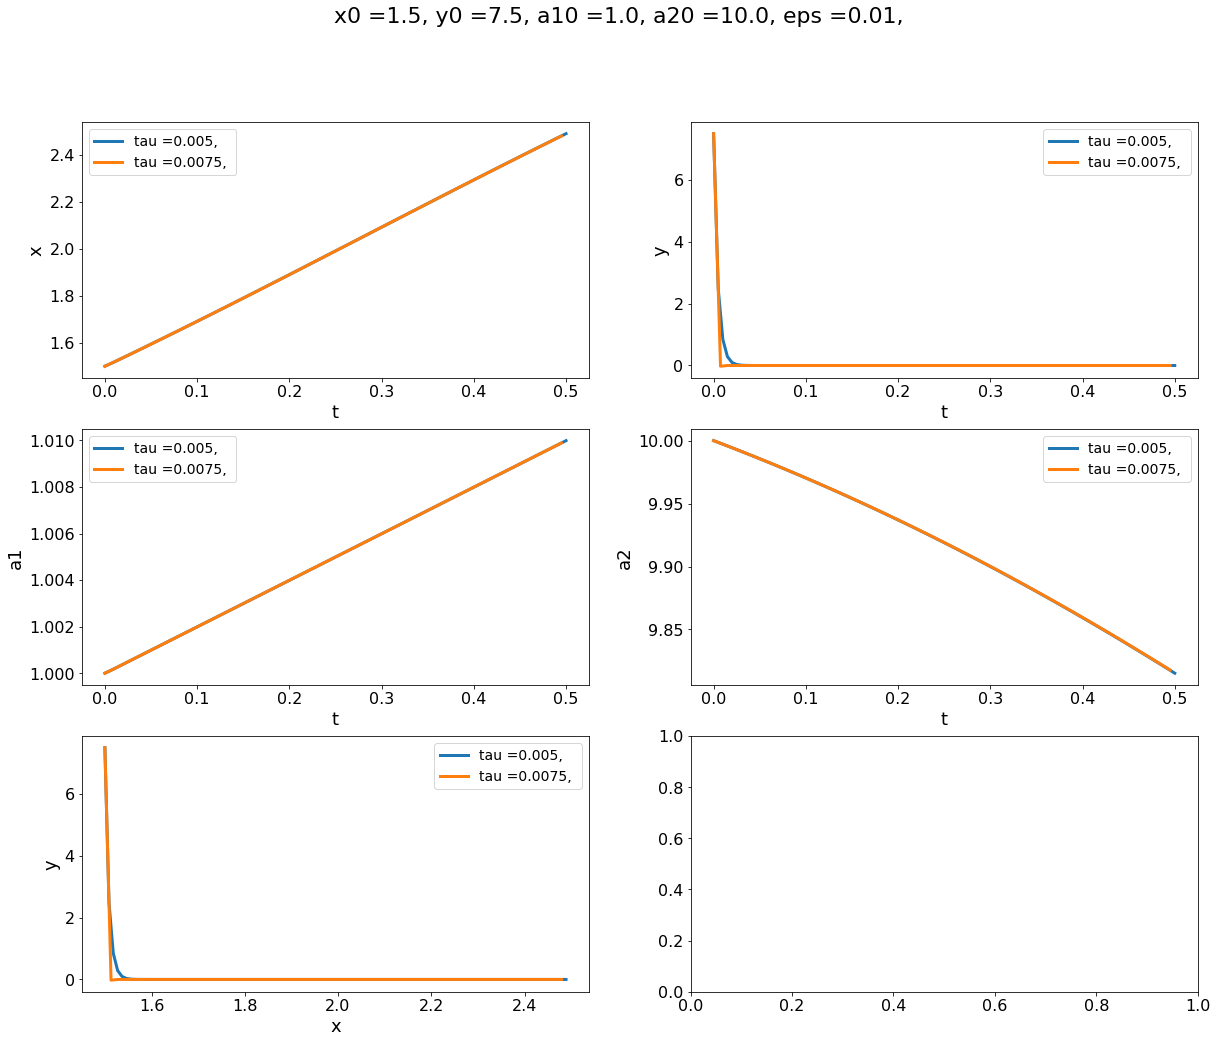

In [317]:
plot_it_problem_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16))

## Метод РК 4-го порядка.

In [ ]:
def calc_evolution_rk_1_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list):
    features_list = ['tau','x0','y0','a10','a20','eps','t','x','y','a1','a2']
    evolution_table = pd.DataFrame(columns=features_list)
    
    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list, a10_list, a20_list, eps_list):
        t = 0
        x = x0; y = y0; a1 = a10; a2 = a20
        row_to_append = pd.Series([tau, x0, y0, a10, a20, eps, t, x, y, a1, a2],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            t+=tau
            b1 = min(a1**(-2),100)
            b2 = min(a2**(-2),100)
            x_new = x + tau*x*(2*a1-0.5*x-a1**2*b2*y)
            y_new = y + tau*y*(2*a2-0.5*y-a2**2*b1*x)
            a1_new = a1 + tau*eps*(2-2*a1*b2*y)
            a2_new = a2 + tau*eps*(2-2*a2*b1*x)
            x = x_new; y = y_new; a1 = a1_new; a2 = a2_new
            row_to_append[:] = tau, x0, y0, a10, a20, eps, t, x, y, a1, a2
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a1),abs(a2)) > 1e5:
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a10','a20','eps'])
    return evolution_table

\begin{gather}
\frac1\tau(x_{n+1} - x_n) = x_n\big(2\alpha_{1,n} - 0.5x_n - \alpha_{1,n}^2\alpha_{2,n}^{-2}y_n\big)\\
\frac1\tau(y_{n+1} - y_n) = y_n\big(2\alpha_{2,n} - \alpha_{1,n}^{-2}\alpha_{2,n}^2x_n - 0.5y_n\big)\\
\frac1\tau(\alpha_{1,n+1} - \alpha_{1,n}) = \varepsilon\big(2 - 2\alpha_{1,n}\alpha_{2,n}^{-2}y_n\big)\\
\frac1\tau(\alpha_{2,n+1} - \alpha_{2,n}) = \varepsilon\big(2 - 2\alpha_{2,n}\alpha_{1,n}^{-2}x_n\big)
\end{gather}

In [232]:
def f(var_list,eps):
    x, y, a1, a2 = var_list
    b1 = min(a1**(-2),100)
    b2 = min(a2**(-2),100)
    d_x = x*(2*a1-0.5*x-a1**2*b2*y)
    d_y = y*(2*a2-0.5*y-a2**2*b1*x)
    d_a1 = eps*(2-2*a1*b2*y)
    d_a2 = eps*(2-2*a2*b1*x)
    return np.array([d_x,d_y,d_a1,d_a2])   

In [326]:
T = 0.5 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([8e-4,1.2e-3], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([20], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([20], name = 'y0') # для y
a10_list = pd.Series([1], name = 'a10') # для alpha
a20_list = pd.Series([10.], name = 'a20') # для alpha

In [327]:
def calc_evolution_rk_4_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list):
    features_list = ['tau','x0','y0','a10','a20','eps','t','x','y','a1','a2']
    evolution_table = pd.DataFrame(columns=features_list)
    
    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list, a10_list, a20_list, eps_list):
        t = 0
        x = x0; y = y0; a1 = a10; a2 = a20
        row_to_append = pd.Series([tau, x0, y0, a10, a20, eps, t, x, y, a1, a2],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            # Здесь начинается метод РК 4-го порядка. 
            vals = np.array([x,y,a1,a2])
            k1 = f(vals,eps)
            k2 = f(vals+tau*k1/2,eps)
            k3 = f(vals+tau*k2/2,eps)
            k4 = f(vals+tau*k3,eps)
            vals_new = vals + tau/6*(k1+2*k2+2*k3+k4)
            t+=tau
            x, y, a1, a2 = vals_new[0], vals_new[1], vals_new[2], vals_new[3]
            row_to_append[:] = tau, x0, y0, a10, a20, eps, t, x, y, a1, a2
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a1),abs(a2)) > 1e5:
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a10','a20','eps'])
    return evolution_table

In [328]:
evolution_table = calc_evolution_rk_4_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
    a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list)

Расхождение при $\tau \approx 0.001 $.

/home/asm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


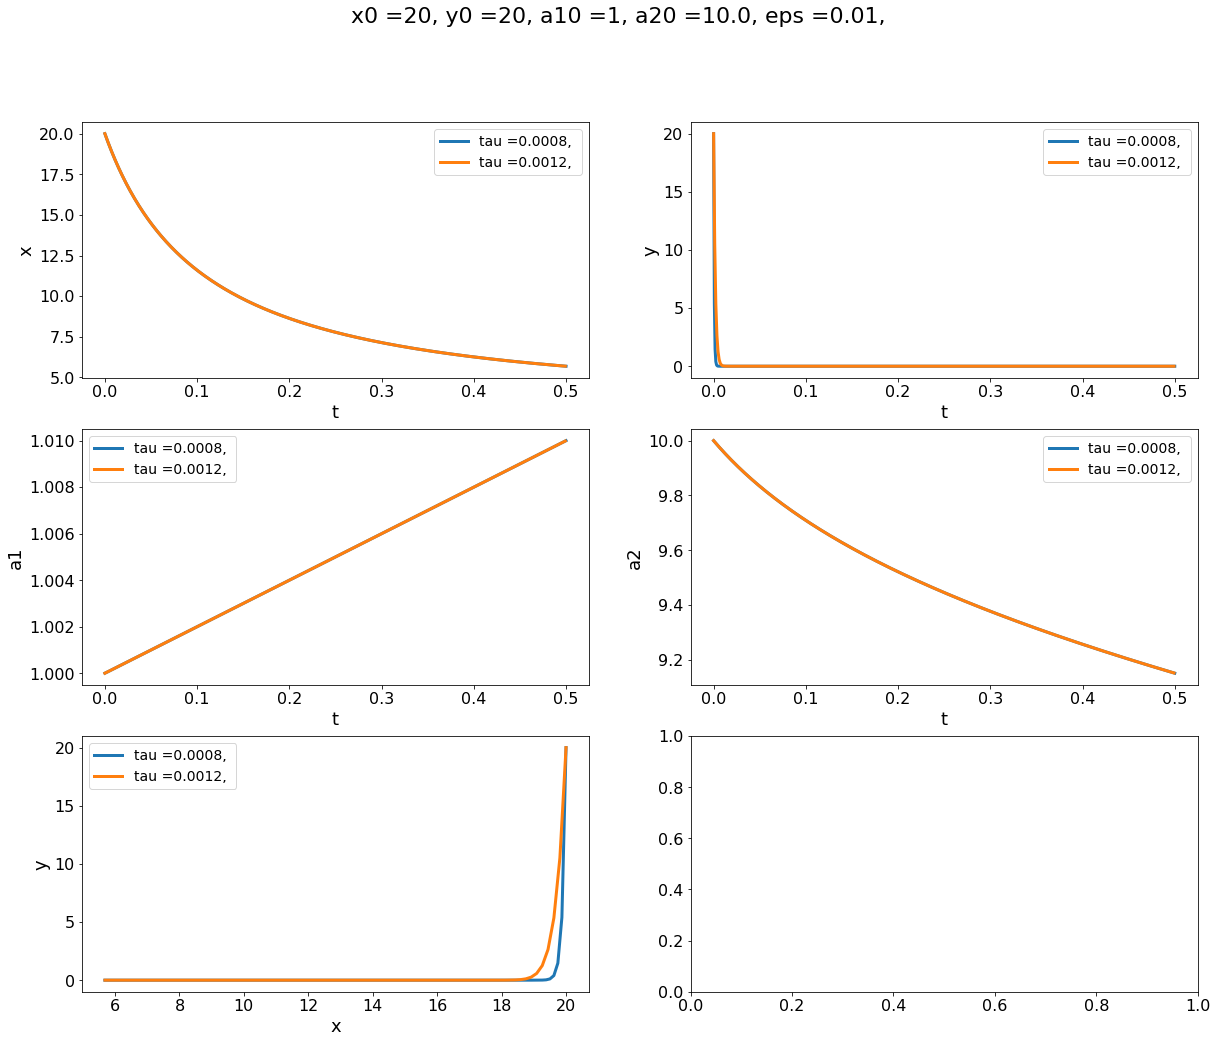

In [329]:
plot_it_problem_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16))

## Неявный метод РК (метод Хаммера-Холлинсворта)

In [336]:
def calc_evolution_hh_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list):
    features_list = ['tau','x0','y0','a10','a20','eps','t','x','y','a1','a2']
    evolution_table = pd.DataFrame(columns=features_list)
    
    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list, a10_list, a20_list, eps_list):
        t = 0
        x = x0; y = y0; a1 = a10; a2 = a20
        row_to_append = pd.Series([tau, x0, y0, a10, a20, eps, t, x, y, a1, a2],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            vals = np.array([x,y,a1,a2])
            k1 = 0; k2 = 0
            for j in range(2):
                k1 = k_1(vals,eps,k1,k2,tau)
                k2 = k_2(vals,eps,k1,k2,tau)
            vals_new = vals + (k1+k2)/2
            t+=tau
            x, y, a1, a2 = vals_new[0], vals_new[1], vals_new[2], vals_new[3]
            row_to_append[:] = tau, x0, y0, a10, a20, eps, t, x, y, a1, a2
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a1),abs(a2)) > 1e5:
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a10','a20','eps'])
    return evolution_table

In [337]:
T = 0.5 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([8e-4,1.2e-3], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([20], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([20], name = 'y0') # для y
a10_list = pd.Series([1], name = 'a10') # для alpha
a20_list = pd.Series([10.], name = 'a20') # для alpha

In [338]:
evolution_table = calc_evolution_hh_problem_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
    a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list)

Снова расхождение при $\tau \approx 0.001$.

/home/asm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


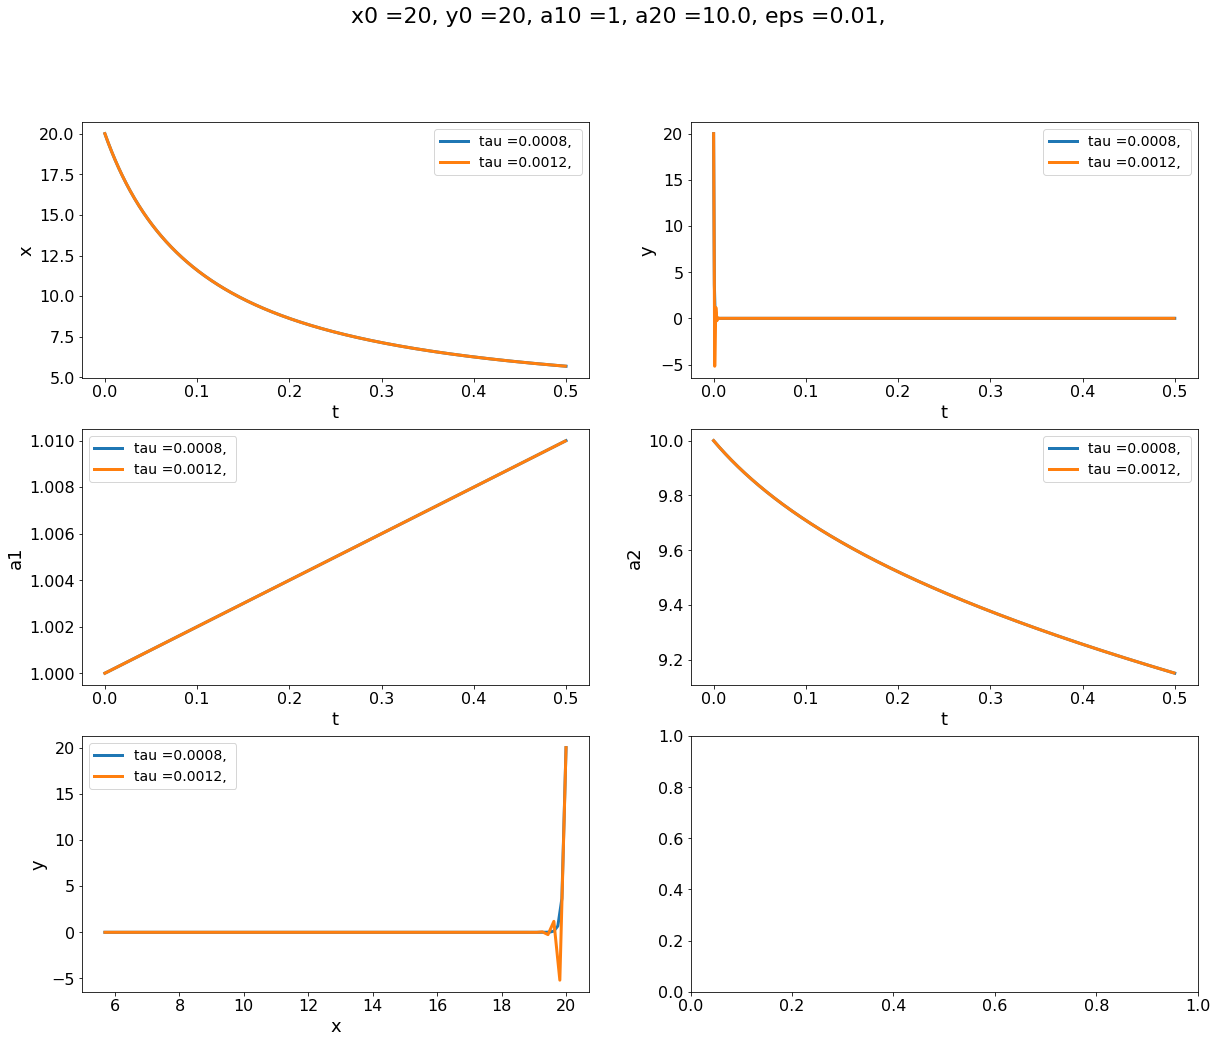

In [339]:
plot_it_problem_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16))

# Модель Лотки-Вольтерры.

In [378]:
def calc_evolution_rk_1_problem_0(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list, eps_list = eps_list, T = T,\
                   tau_list = tau_list):
    '''
    Input:
    tau_list, x0_list, y0_list, a0_list, eps_list : списки значений шага tau, начальных условий x0, y0,
        a0 и параметра epsilon
    T : конечный момент времени

    Output:
    evolution_table : pd.DataFrame - таблица с историей эволюции для каждой комбинации параметров
    '''
    features_list = ['tau','x0','y0','a0','eps','t','x','y','a'] # названия столбцов в итоговой таблице
    evolution_table = pd.DataFrame(columns=features_list) # таблица, в которую будем записывать данные
    
    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        t = 0
        x = x0; y = y0; a = a0
        row_to_append = pd.Series([tau, x0, y0, a0, eps, t, x, y, a],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            # Здесь начинается метод РК 1-го порядка. Так как альфа может быть 0, то перед его возведением в -1
            # степень ограничим альфу снизу до 0.1 по модулю.
            t+=tau
            x_new = x + tau*x*(a - y)
            y_new = y + tau*y*(0.5*x-a)
            a_new = a + tau*eps*(1-a*x)
            x = x_new; y = y_new; a = a_new
            row_to_append[:] = tau, x0, y0, a0, eps, t, x, y, a
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a)) > 1e5: # если переполнение - то останавливаемся
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a0','eps'])
    return evolution_table

In [382]:
T = 200 # конечный момент времени
eps_list = pd.Series([1e-1], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.03], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a0_list = pd.Series([1], name = 'a0') # для alpha

In [383]:
evolution_table = calc_evolution_rk_1_problem_0(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

/home/asm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


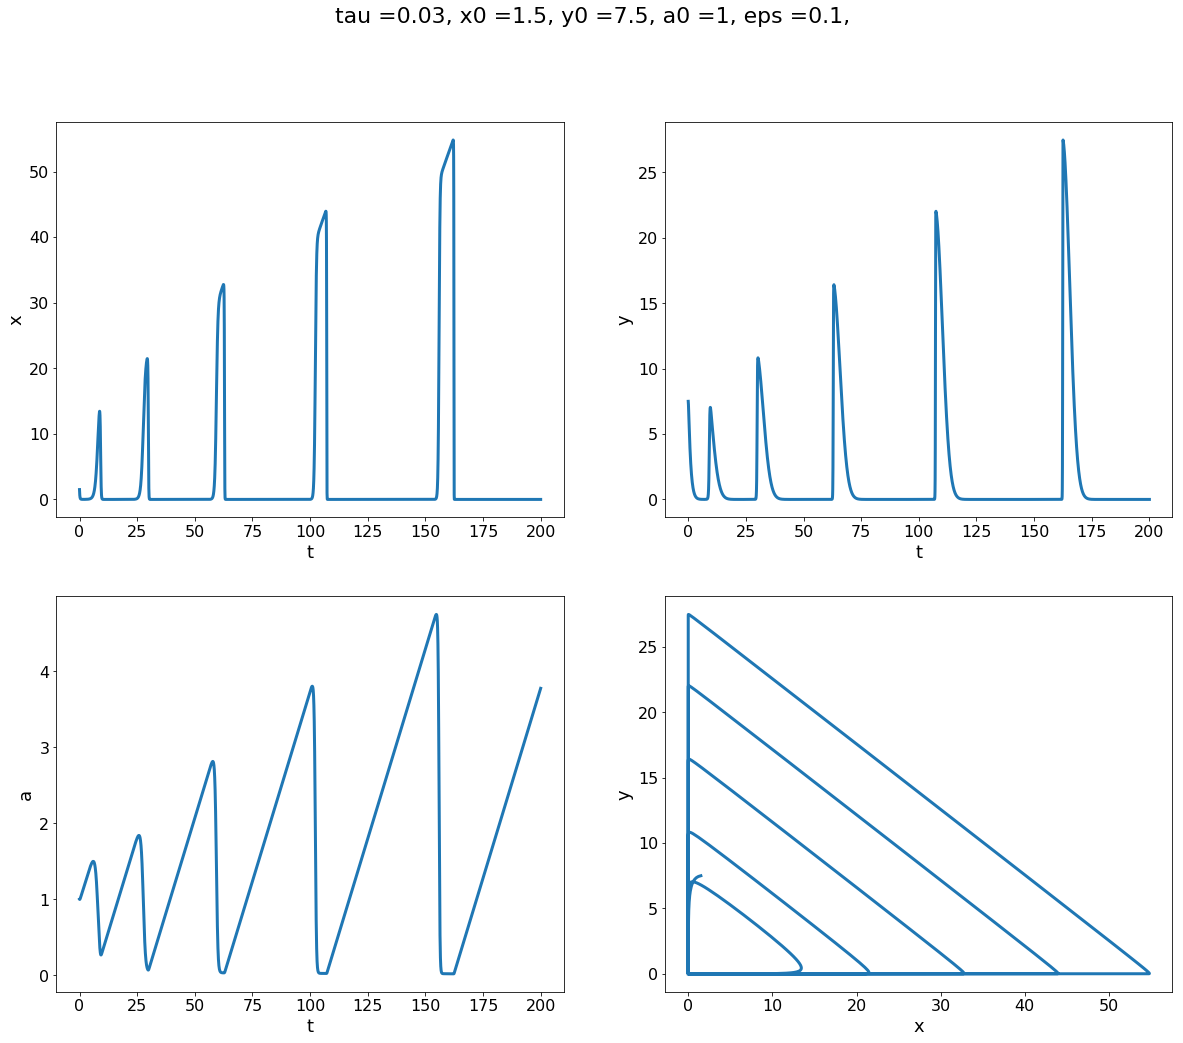

In [384]:
plot_it_problem_1(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))